In [1]:
# Import necessary libraries
# - `geopandas` for geographic data manipulation
# - `matplotlib.pyplot` for visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the Business Improvement Districts (BIDs) dataset
# `bid_data` includes geographic boundaries of BIDs across NYC.
bid_data = gpd.read_file('../common_files/NYC_BIDS_09112015.csv', encoding='utf-8')

In [3]:
bid_data.head()

,the_geom,Id,OBJECTID_1,OBJECTID_2,Shape_Leng,F_ALL_BIDs,F_ALL_BI_1,F_ALL_BI_2,F_ALL_BI_3,F_ALL_BI_4,F_ALL_BI_6,F_ALL_BI_7,Shape_Le_1,Shape_Ar_1,Year_Found,Shape_Area
0,MULTIPOLYGON (((-73.94296015325146 40.73949166...,0,0,0,0,0,Queens,Long Island City Partnership,0,https://www.longislandcityqueens.com/,0,0,0,0,2005,0
1,MULTIPOLYGON (((-73.89166191549769 40.67759930...,0,0,0,0,0,Brooklyn,Cypress Hills Fulton,0,https://cypresshillsfultonbid.org/,0,0,0,0,2023,0
2,MULTIPOLYGON (((-73.98282323348212 40.73130538...,0,0,1,0,0,Manhattan,Union Square Partnership,892,https://www.unionsquarenyc.org/,3400000,3950623,25744.4695903,1275270.53685,1984,206555.808776
3,MULTIPOLYGON (((-73.9419337956347 40.806137014...,0,0,2,0,0,Manhattan,125th Street,220,https://www.125thstreet.nyc/,1240462,1289475,18167.7930477,982675.507591,1994,159516.90573
4,MULTIPOLYGON (((-73.9188925538744 40.825078988...,0,0,3,0,1,Bronx,161st Street,145,http://www.161bid.com/,1687028,506873,16588.0134708,1303742.08624,2005,211748.007845


In [4]:
# load geojson file
kpfui_dev_data = gpd.read_file('./files/kpfui_dev.json')

In [5]:
bid_gdf = gpd.GeoDataFrame(
    bid_data,
    geometry=gpd.GeoSeries.from_wkt(bid_data['the_geom']),
)

In [6]:
# Filter for West Village BID
wv_bid = bid_gdf[bid_gdf['F_ALL_BI_2'] == 'West Village']
# Use `explode` to ensure each geometry component is in a separate row, simplifying spatial analysis
exploded_wv_data = wv_bid.explode()

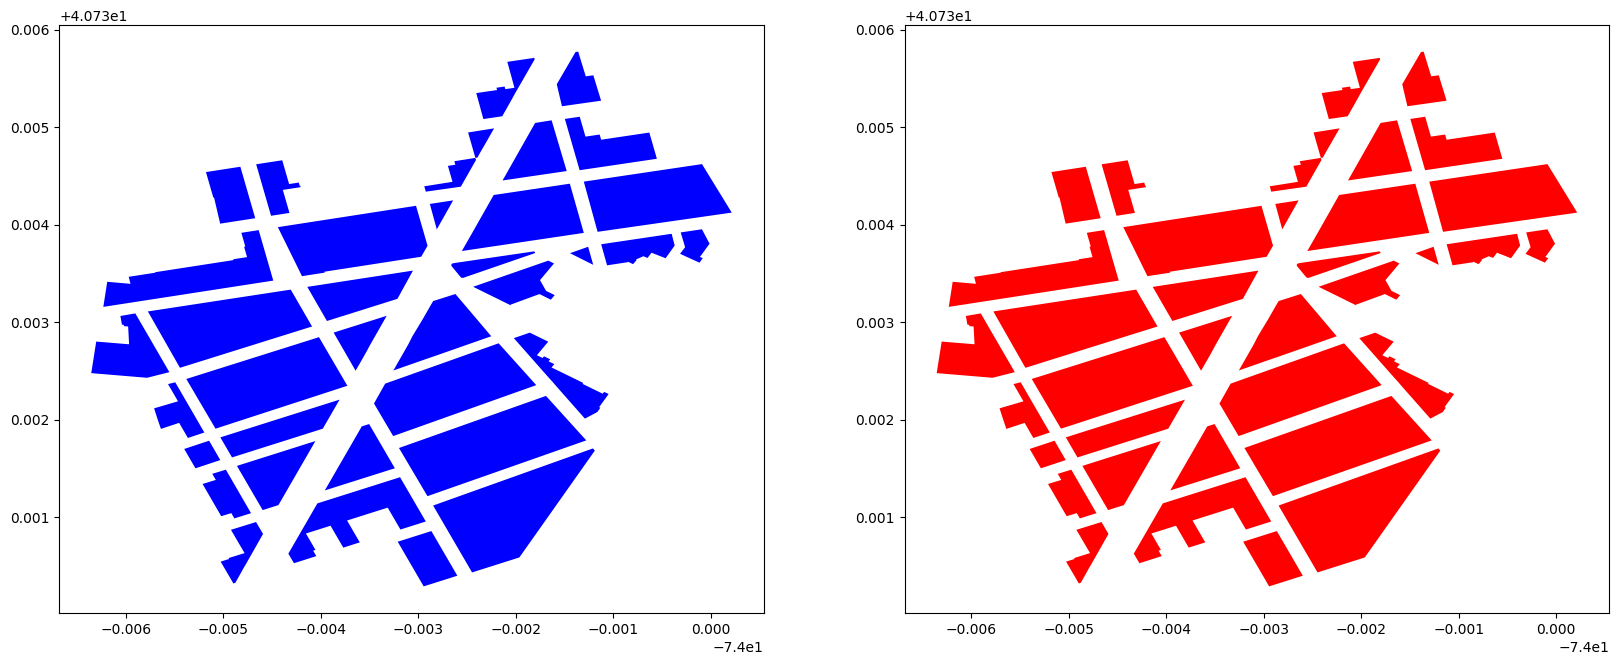

In [7]:
# plot the two datasets side by side
fig, ax = plt.subplots(1, 2,  figsize=(20, 10))

# plot the bid_data_objectid_2_0 geodataframe
wv_bid.plot(ax=ax[0], color='blue', markersize=.01)
# plot the exploded geodataframe
exploded_wv_data.plot(ax=ax[1], color='red', markersize=.01)
exploded_wv_data.set_crs(epsg=4326, inplace=True)
plt.show()

In [8]:
# Create a buffered version of the BID boundaries
# Buffer distance in degrees (for EPSG:4326) - adjust as needed
# ~0.0001 degrees is roughly 10-11 meters at NYC's latitude
buffer_distance = 0.0002 
buffered_wv_data = exploded_wv_data.copy()
buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23184\3212709067.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)


In [9]:
# Spatial join directly without bbox filtering
kpfui_dev_within_bbox = gpd.sjoin(
    kpfui_dev_data, 
    buffered_wv_data, 
    how='inner', 
    predicate='intersects'
)
print("Number of sidewalks found:", len(kpfui_dev_within_bbox))

Number of sidewalks found: 665


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23184\823117546.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


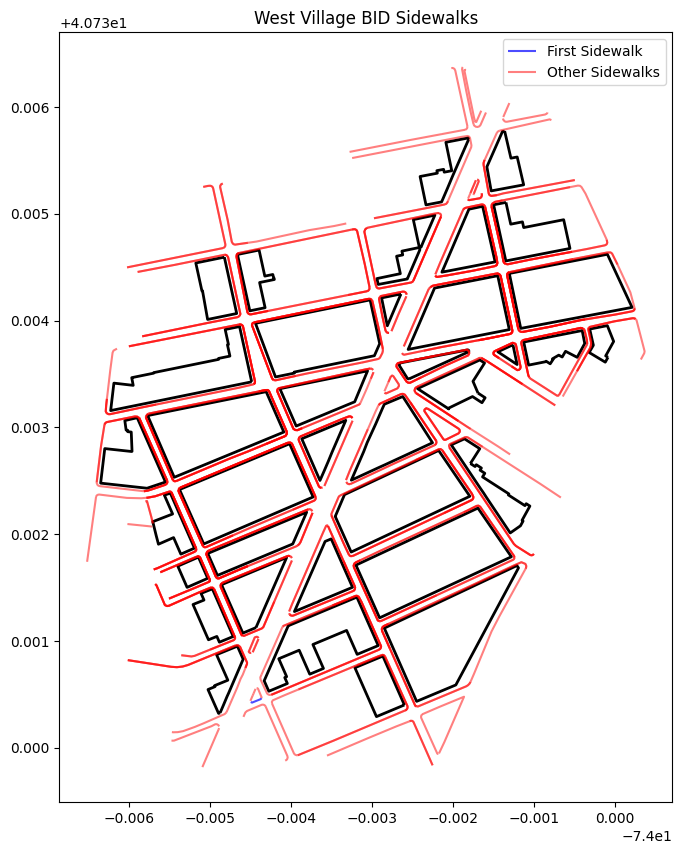

In [10]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the BID boundary
wv_bid.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='BID Boundary')

# Split the sidewalks dataframe into first row and rest
if len(kpfui_dev_within_bbox) > 0:
    first_row = kpfui_dev_within_bbox.iloc[[0]]
    rest_rows = kpfui_dev_within_bbox.iloc[1:] if len(kpfui_dev_within_bbox) > 1 else None
    
    # Plot the first row in blue
    first_row.plot(ax=ax, color='blue', alpha=0.7, label='First Sidewalk')
    
    # Plot the rest in red (if there are any)
    if rest_rows is not None and len(rest_rows) > 0:
        rest_rows.plot(ax=ax, color='red', alpha=0.5, label='Other Sidewalks')
else:
    print("No sidewalks found to plot")

# Add labels and title
plt.title('West Village BID Sidewalks')
plt.legend()

# Show the plot
plt.show()

In [11]:
# Save the processed sidewalk data as GeoJSON
kpfui_dev_within_bbox.to_file("./files/kpfui_dev_within_bbox.json", driver='GeoJSON')

# Save the BID boundary as GeoJSON
wv_bid.to_file("./files/wv_bid.json", driver='GeoJSON')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [12]:
# Get and display all column names
kpfui_dev_within_bbox.columns

Index(['area', 'p_total_9', 'area_p_9', 'p_walk_9', 'p_queue_9', 'rest_9',
       'supe_9', 'phar_9', 'bank_9', 'offi_9', 'subw_9', 'p_total_12',
       'area_p_12', 'p_walk_12', 'p_queue_12', 'rest_12', 'supe_12', 'phar_12',
       'bank_12', 'offi_12', 'subw_12', 'p_total_19', 'area_p_19', 'p_walk_19',
       'p_queue_19', 'rest_19', 'supe_19', 'phar_19', 'bank_19', 'offi_19',
       'subw_19', 'geometry', 'index_right', 'the_geom', 'Id', 'OBJECTID_1',
       'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2',
       'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1',
       'Shape_Ar_1', 'Year_Found', 'Shape_Area'],
      dtype='object')

In [13]:
kpfui_dev_within_bbox.head(1)["geometry"]

1016    LINESTRING (-74.00436 40.73046, -74.00437 40.7...
Name: geometry, dtype: geometry